In [ ]:
"""
LightFM com likes (+1) e dislikes (–1)
--------------------------------------
• Cada (user,item) recebe uma soma de avaliações: +N likes, –M dislikes
• Usa loss='logistic' (aceita valores negativos)
• sample_weight = |soma|  → frequência/confiança
"""
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from lightfm import LightFM

# -----------------------------
# 1. Gerar dados sintéticos (likes / dislikes)
# -----------------------------
np.random.seed(42)
num_users         = 10
num_items         = 8
num_interactions  = 3_000

df = pd.DataFrame({
    "user_id" : np.random.randint(0, num_users,  num_interactions),
    "item_id" : np.random.randint(0, num_items, num_interactions),
    "rating"  : np.random.choice([+1, -1], size=num_interactions, p=[0.8, 0.2])  # 80 % likes, 20 % dislikes
})

df[df["item_id" == 0 ]] == -1

# -------------------------------------------------
# 2. Agregar: soma de likes (+) e dislikes (–)
# -------------------------------------------------
agg = (
    df.groupby(["user_id", "item_id"])["rating"]
      .sum()                       # pode ficar negativo
      .reset_index()
)

# Matriz de RATING (pode ter –X … +Y)
ratings_mat = coo_matrix(
    (agg.rating.astype(float), (agg.user_id, agg.item_id)),
    shape=(num_users, num_items)
)

# Matriz de PESOS = |rating|  (mais interações ⇒ maior confiança)
weights_mat = coo_matrix(
    (agg.rating.abs().astype(float), (agg.user_id, agg.item_id)),
    shape=(num_users, num_items)
)

# -----------------------------
# 3. Treinar modelo LightFM (LOGISTIC aceita negativos)
# -----------------------------
model = LightFM(loss="logistic")
model.fit(
    ratings_mat,
    sample_weight=weights_mat,
    epochs=20,
    num_threads=2
)

# -----------------------------
# 4. Fazer recomendações
# -----------------------------
user_id  = 0
scores   = model.predict(user_id, np.arange(num_items))
top_idx  = np.argsort(-scores)

df_recommendation = pd.DataFrame({
    "item_id": top_idx,
    "score":  scores[top_idx]
}).reset_index(drop=True)

# -----------------------------
# 5. Mostrar resultados
# -----------------------------
print("📄 Amostra de interações (likes / dislikes)")
display(df.sort_values(["user_id", "item_id"]).head(25))

print("\n🎯 Recomendações para o usuário", user_id)
display(df_recommendation)

print("\n📊 Tabela de contingência (contagem bruta)")
df_contingencia = pd.crosstab(df['user_id'], df['item_id']).reset_index()
display(df_contingencia.head())


📄 Amostra de interações (likes / dislikes)


,user_id,item_id,rating
51,0,0,1
124,0,0,-1
275,0,0,1
276,0,0,1
344,0,0,1
507,0,0,1
579,0,0,-1
654,0,0,1
774,0,0,-1
895,0,0,-1



🎯 Recomendações para o usuário 0


,item_id,score
0,6,6.028409
1,7,6.009327
2,0,5.991396
3,1,5.923666
4,2,5.883955
5,5,5.851664
6,3,5.814887
7,4,5.800805



📊 Tabela de contingência (contagem bruta)


item_id,user_id,0,1,2,3,4,5,6,7
0,0,33,35,36,40,34,45,49,47
1,1,29,37,42,44,32,34,31,41
2,2,37,38,49,39,44,38,31,35
3,3,38,31,38,35,40,32,38,39
4,4,46,38,39,32,50,47,26,37


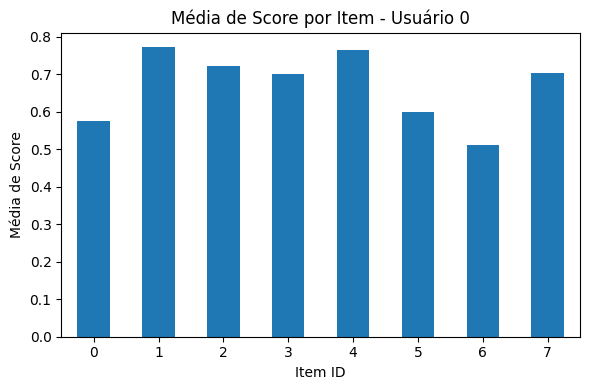

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtra usuário 0
df_user0 = df[df['user_id'] == 0]

# Média de rating por item
mean_scores = df_user0.groupby('item_id')['rating'].mean()

# Gráfico
plt.figure(figsize=(6,4))
mean_scores.plot(kind='bar')
plt.title('Média de Score por Item - Usuário 0')
plt.xlabel('Item ID')
plt.ylabel('Média de Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()